In [1]:
## Create a Siamese Network with Triplet Loss in Keras
import socket
print(socket.gethostname())

psanagpu110


In [2]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import h5py
from sklearn.decomposition import PCA

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
particle2idx = {
    '1fpv': 0,
    '1ss8': 1,
    '3j03': 2,
    '1ijg': 3,
    '3iyf': 4,
    '6ody': 5,
    '6sp2': 6,
    '6xs6': 7,
    '7dwz': 8,
    '7dx8': 9,
    '7dx9': 10
}

count2idx = {
    'single': 0,
    'double': 1,
    'triple': 2,
    'quadruple': 3
}

hit2idx = {
    'single_hit': 0,
    'multi_hit': 1
}

In [4]:
idx2particle = {
    0: '1fpv',
    1: '1ss8',
    2: '3j03',
    3: '1ijg',
    4: '3iyf',
    5: '6ody',
    6: '6sp2',
    7: '6xs6',
    8: '7dwz',
    9: '7dx8',
    10: '7dx9'
}

idx2count = {
    0: 'single',
    1: 'double',
    2: 'triple',
    3: 'quadruple'
}

idx2hit = {
    0: 'single_hit',
    1: 'multi_hit'
}

# Data Augmentation

In [5]:
def addNoise(orig_img, flux_jitter=0.9, gaussian_noise=0.15):

    def changeIntensity(img, flux_jitter):
        factor = 100 # FIXME: correct for data which has 100 more flux
        mu = 1 # mean jitter
        alpha = np.random.normal(mu, flux_jitter)
        if alpha <= 0: alpha = 0.1 # alpha can't be zero
        n_photons = alpha*np.sum(img) / factor                     # number of desired photons per image
        return n_photons*(img/np.sum(img)) # cache noise-free measurement
    
    def poisson(img):
        # add poisson noise
        return np.random.poisson(img)      # apply Poisson statistics
    
    def gaussian(img, sigma):
        # add gaussian noise 
        # For random samples from N(\mu, \sigma^2), 
        # mu + sigma * np.random.randn(...)
        # sigma: Gaussian noise level
        img = img + sigma*np.random.randn(*img.shape);  # apply Gaussian statistics
        return img
    
    def varNorm(V):
        # variance normalization, each image has mean 0, variance 1
        # This shouldn't happen, but zero out infinite pixels
        V[np.argwhere(V==np.inf)] = 0
        mean = np.mean(V)
        std = np.std(V)
        if std == 0:
            return np.zeros_like(V)
        V1 = (V-mean)/std
        return V1
    
    def rotation_transform(img, rotation_range):
        img = np.expand_dims(img, axis=2)
        img = tf.keras.preprocessing.image.random_rotation(x=img, rg=rotation_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.0)
        img = np.squeeze(img)
        return img
    
    def vertical_flip_transform(img):
        img = np.expand_dims(img, axis=2)
        img = tf.image.random_flip_left_right(img).numpy()
        img = np.squeeze(img)
        return img
    
    def horizontal_flip_transform(img):
        img = np.expand_dims(img, axis=2)
        img = tf.image.random_flip_up_down(img).numpy()
        img = np.squeeze(img)
        return img
    
    def zoom_transform(img, zoom_range):
        img = np.expand_dims(img, axis=2)
        img = tf.keras.preprocessing.image.random_zoom(x=img, zoom_range=zoom_range, row_axis=0, col_axis=1, channel_axis=2,
                                                       fill_mode='nearest', cval=0.0)
        img = np.squeeze(img)
        return img
        

    def transform(img):
        # Apply rotation, flips, and zooms before other noise.
        img = rotation_transform(img, rotation_range=360)
        img = vertical_flip_transform(img)
        img = horizontal_flip_transform(img)
        img = zoom_transform(img, zoom_range=(0.9, 1.1))
        
        img = changeIntensity(img, flux_jitter)
        img = poisson(img)
        img = gaussian(img, gaussian_noise)
        img = varNorm(img)
        return img
    
    # "orig_img" is actually a "mini-batch" of images.
    # This loops applies the transforms to every image in that "mini-batch"
    for i in range(orig_img.shape[0]):
        orig_img[i] = transform(img=orig_img[i])
    
    return orig_img

# Data Loader Function

#### Loads data and label them by count

In [6]:
def load_data(num_train_samples=200, num_test_samples=50, normalize=None, seed=None):
    """
    num_train_samples: number of training samples
    num_test_samples: number of test samples
    normalize: type of intensity normalization {'variance'}
    seed: random seed
    """
    # num_train_sample must be divisible by 2
    path = '/reg/data/ana03/scratch/xericfl/DeepProjection/DeepProjection/resnet/eric_data/'
    
    ### Change these names
    fnames = ['1fpv_5k_single_pps_1e14_thumbnail.h5',
            '6sp2_5k_single_pps_1e14_thumbnail.h5',
            '1ijg_5k_single_pps_1e14_thumbnail.h5',
            '6xs6_5k_single_pps_1e14_thumbnail.h5',
            '1ss8_5k_single_pps_1e14_thumbnail.h5',
            '7dwz_5k_single_pps_1e14_thumbnail.h5',
            '3iyf_5k_single_pps_1e14_thumbnail.h5',
            '7dx8_5k_single_pps_1e14_thumbnail.h5',
            '3j03_5k_single_pps_1e14_thumbnail.h5',
            '7dx9_5k_single_pps_1e14_thumbnail.h5',
            '6ody_5k_single_pps_1e14_thumbnail.h5',
            '1fpv_5k_double_pps_1e14_thumbnail.h5',
            '6sp2_5k_double_pps_1e14_thumbnail.h5',
            '1ijg_5k_double_pps_1e14_thumbnail.h5',
            '6xs6_5k_double_pps_1e14_thumbnail.h5',
            '1ss8_5k_double_pps_1e14_thumbnail.h5',
            '7dwz_5k_double_pps_1e14_thumbnail.h5',
            '3iyf_5k_double_pps_1e14_thumbnail.h5',
            '7dx8_5k_double_pps_1e14_thumbnail.h5',
            '3j03_5k_double_pps_1e14_thumbnail.h5',
            '7dx9_5k_double_pps_1e14_thumbnail.h5',
            '6ody_5k_double_pps_1e14_thumbnail.h5',
            '1fpv_5k_triple_pps_1e14_thumbnail.h5',
            '6sp2_5k_triple_pps_1e14_thumbnail.h5',
            '1ijg_5k_triple_pps_1e14_thumbnail.h5',
            '6xs6_5k_triple_pps_1e14_thumbnail.h5',
            '1ss8_5k_triple_pps_1e14_thumbnail.h5',
            '7dwz_5k_triple_pps_1e14_thumbnail.h5',
            '3iyf_5k_triple_pps_1e14_thumbnail.h5',
            '7dx8_5k_triple_pps_1e14_thumbnail.h5',
            '3j03_5k_triple_pps_1e14_thumbnail.h5',
            '7dx9_5k_triple_pps_1e14_thumbnail.h5',
            '6ody_5k_triple_pps_1e14_thumbnail.h5',
            '1fpv_5k_quadruple_pps_1e14_thumbnail.h5',
            '6sp2_5k_quadruple_pps_1e14_thumbnail.h5',
            '1ijg_5k_quadruple_pps_1e14_thumbnail.h5',
            '6xs6_5k_quadruple_pps_1e14_thumbnail.h5',
            '1ss8_5k_quadruple_pps_1e14_thumbnail.h5',
            '7dwz_5k_quadruple_pps_1e14_thumbnail.h5',
            '3iyf_5k_quadruple_pps_1e14_thumbnail.h5',
            '7dx8_5k_quadruple_pps_1e14_thumbnail.h5',
            '3j03_5k_quadruple_pps_1e14_thumbnail.h5',
            '7dx9_5k_quadruple_pps_1e14_thumbnail.h5',
            '6ody_5k_quadruple_pps_1e14_thumbnail.h5']
            
    numFiles = len(fnames)
    
    if seed is not None: 
        np.random.seed(seed)
    # Get image dimensions
    with h5py.File(path+fnames[0],'r') as f:
        img = f['photons'][0,:,:]
        nR,nC = img.shape
            
    # TRAIN
    x_train = np.empty((num_train_samples, nR, nC), dtype='float32')
    y_train = np.empty((num_train_samples,), dtype='uint8')
    index = np.random.randint(0, numFiles, num_train_samples)
    for i, fname in enumerate(fnames):
        ind = np.where(index == i)[0]
        if len(ind) > 0:
            with h5py.File(path+fname,'r') as f:
                
                x_train[ind] = addNoise(f['photons'][0:len(ind),:,:], flux_jitter=0.9, gaussian_noise=0.15)
                print(fname, len(ind))
                
                # Get particle count
                if 'single' in fname:
                    y_train[ind] = hit2idx['single_hit']
                elif ('double' in fname) or ('triple' in fname) or ('quadruple' in fname):
                    y_train[ind] = hit2idx['multi_hit']
                else:
                    raise Exception('Unknown file being processed. Be sure that one of the following count types are in the file name: \"single\", \"double\", \"triple\", or \"quadruple\"')


    # TEST
    x_test = np.empty((num_test_samples, nR, nC), dtype='float32')
    y_test = np.empty((num_test_samples,), dtype='uint8')
    index = np.random.randint(0,numFiles,num_test_samples)
    for i, fname in enumerate(fnames):
        ind = np.where(index == i)[0] 
        if len(ind) > 0:
            with h5py.File(path+fname,'r') as f:
                # apply offset since first num_train_samples have been used
                offset = round(num_train_samples/numFiles)
                
                x_test[ind] = addNoise(f['photons'][offset:len(ind)+offset,:,:], flux_jitter=0.9, gaussian_noise=0.15)
                    
                if 'single' in fname:
                    y_test[ind] = hit2idx['single_hit']
                elif ('double' in fname) or ('triple' in fname) or ('quadruple' in fname):
                    y_test[ind] = hit2idx['multi_hit']
                else:
                    raise Exception('Unknown file being processed. Be sure that one of the following count types are in the file name: \"single\", \"double\", \"triple\", or \"quadruple\"')

    
    return (x_train, y_train), (x_test, y_test)

#### Loads data and label them by PDB ID.

In [7]:
# Import diffraction image set

# def load_data(num_train_samples=200, num_test_samples=50, normalize=None, seed=None):
#     """
#     num_train_samples: number of training samples
#     num_test_samples: number of test samples
#     normalize: type of intensity normalization {'variance'}
#     seed: random seed
#     """
#     # num_train_sample must be divisible by 2
#     path = '/reg/data/ana03/scratch/xericfl/DeepProjection/DeepProjection/resnet/eric_data/'
    
#     ### Change these names
#     fnames = ['1fpv_5k_single_pps_1e14_thumbnail.h5',
#             '6sp2_5k_single_pps_1e14_thumbnail.h5',
#             '1ijg_5k_single_pps_1e14_thumbnail.h5',
#             '6xs6_5k_single_pps_1e14_thumbnail.h5',
#             '1ss8_5k_single_pps_1e14_thumbnail.h5',
#             '7dwz_5k_single_pps_1e14_thumbnail.h5',
#             '3iyf_5k_single_pps_1e14_thumbnail.h5',
#             '7dx8_5k_single_pps_1e14_thumbnail.h5',
#             '3j03_5k_single_pps_1e14_thumbnail.h5',
#             '7dx9_5k_single_pps_1e14_thumbnail.h5',
#             '6ody_5k_single_pps_1e14_thumbnail.h5',
#             '1fpv_5k_double_pps_1e14_thumbnail.h5',
#             '6sp2_5k_double_pps_1e14_thumbnail.h5',
#             '1ijg_5k_double_pps_1e14_thumbnail.h5',
#             '6xs6_5k_double_pps_1e14_thumbnail.h5',
#             '1ss8_5k_double_pps_1e14_thumbnail.h5',
#             '7dwz_5k_double_pps_1e14_thumbnail.h5',
#             '3iyf_5k_double_pps_1e14_thumbnail.h5',
#             '7dx8_5k_double_pps_1e14_thumbnail.h5',
#             '3j03_5k_double_pps_1e14_thumbnail.h5',
#             '7dx9_5k_double_pps_1e14_thumbnail.h5',
#             '6ody_5k_double_pps_1e14_thumbnail.h5',
#             '1fpv_5k_triple_pps_1e14_thumbnail.h5',
#             '6sp2_5k_triple_pps_1e14_thumbnail.h5',
#             '1ijg_5k_triple_pps_1e14_thumbnail.h5',
#             '6xs6_5k_triple_pps_1e14_thumbnail.h5',
#             '1ss8_5k_triple_pps_1e14_thumbnail.h5',
#             '7dwz_5k_triple_pps_1e14_thumbnail.h5',
#             '3iyf_5k_triple_pps_1e14_thumbnail.h5',
#             '7dx8_5k_triple_pps_1e14_thumbnail.h5',
#             '3j03_5k_triple_pps_1e14_thumbnail.h5',
#             '7dx9_5k_triple_pps_1e14_thumbnail.h5',
#             '6ody_5k_triple_pps_1e14_thumbnail.h5',
#             '1fpv_5k_quadruple_pps_1e14_thumbnail.h5',
#             '6sp2_5k_quadruple_pps_1e14_thumbnail.h5',
#             '1ijg_5k_quadruple_pps_1e14_thumbnail.h5',
#             '6xs6_5k_quadruple_pps_1e14_thumbnail.h5',
#             '1ss8_5k_quadruple_pps_1e14_thumbnail.h5',
#             '7dwz_5k_quadruple_pps_1e14_thumbnail.h5',
#             '3iyf_5k_quadruple_pps_1e14_thumbnail.h5',
#             '7dx8_5k_quadruple_pps_1e14_thumbnail.h5',
#             '3j03_5k_quadruple_pps_1e14_thumbnail.h5',
#             '7dx9_5k_quadruple_pps_1e14_thumbnail.h5',
#             '6ody_5k_quadruple_pps_1e14_thumbnail.h5']
    
#     numFiles = len(fnames)
    
#     if seed is not None: 
#         np.random.seed(seed)
#     # Get image dimensions
#     with h5py.File(path+fnames[0],'r') as f:
#         img = f['photons'][0,:,:]
#         nR,nC = img.shape
            
#     # TRAIN
#     x_train = np.empty((num_train_samples, nR, nC), dtype='float32')
#     y_train = np.empty((num_train_samples,), dtype='uint8')
#     index = np.random.randint(0,numFiles,num_train_samples)
#     for i, fname in enumerate(fnames):
#         ind = np.where(index == i)[0]
#         if len(ind) > 0:
#             with h5py.File(path+fname,'r') as f:
#                 x_train[ind] = f['photons'][0:len(ind),:,:]
#                 print(fname, len(ind))
                
#                 for idx in range(len(idx2particle)):
#                     if idx2particle[idx] in fname:
#                         y_train[ind] = idx
                

#     # TEST
#     x_test = np.empty((num_test_samples, nR, nC), dtype='float32')
#     y_test = np.empty((num_test_samples,), dtype='uint8')
#     index = np.random.randint(0,numFiles,num_test_samples)
#     for i, fname in enumerate(fnames):
#         ind = np.where(index == i)[0] 
#         if len(ind) > 0:
#             with h5py.File(path+fname,'r') as f:
#                 # apply offset since first num_train_samples have been used
#                 offset = round(num_train_samples/numFiles)
#                 x_test[ind] = f['photons'][offset:len(ind)+offset,:,:]
                
#                 for idx in range(len(idx2particle)):
#                     if idx2particle[idx] in fname:
#                         y_test[ind] = idx
        
#     #x_train = tf.expand_dims(x_train, axis=1)
#     #x_train = x_train.numpy()

#     #x_test = tf.expand_dims(x_test, axis=1)
#     #x_test = x_test.numpy()
    
#     return (x_train, y_train), (x_test, y_test)

In [8]:
# Load data
(x_train, y_train), (x_test, y_test) = load_data(num_train_samples=200, num_test_samples=50, normalize=None, seed=None)

1fpv_5k_single_pps_1e14_thumbnail.h5 7
6sp2_5k_single_pps_1e14_thumbnail.h5 1
1ijg_5k_single_pps_1e14_thumbnail.h5 3
6xs6_5k_single_pps_1e14_thumbnail.h5 6
1ss8_5k_single_pps_1e14_thumbnail.h5 5
7dwz_5k_single_pps_1e14_thumbnail.h5 4
3iyf_5k_single_pps_1e14_thumbnail.h5 5
7dx8_5k_single_pps_1e14_thumbnail.h5 4
3j03_5k_single_pps_1e14_thumbnail.h5 4
7dx9_5k_single_pps_1e14_thumbnail.h5 6
6ody_5k_single_pps_1e14_thumbnail.h5 2
1fpv_5k_double_pps_1e14_thumbnail.h5 5
6sp2_5k_double_pps_1e14_thumbnail.h5 3
1ijg_5k_double_pps_1e14_thumbnail.h5 3
6xs6_5k_double_pps_1e14_thumbnail.h5 1
1ss8_5k_double_pps_1e14_thumbnail.h5 4
7dwz_5k_double_pps_1e14_thumbnail.h5 2
3iyf_5k_double_pps_1e14_thumbnail.h5 9
7dx8_5k_double_pps_1e14_thumbnail.h5 9
3j03_5k_double_pps_1e14_thumbnail.h5 6
7dx9_5k_double_pps_1e14_thumbnail.h5 3
6ody_5k_double_pps_1e14_thumbnail.h5 6
1fpv_5k_triple_pps_1e14_thumbnail.h5 7
6sp2_5k_triple_pps_1e14_thumbnail.h5 2
1ijg_5k_triple_pps_1e14_thumbnail.h5 5
6xs6_5k_triple_pps_1e14_t

In [9]:
# vectorize dataset
print(x_train.shape)
(num_train, dim_r, dim_c) = x_train.shape
num_test = x_test.shape[0]
img_dim = dim_r * dim_c

x_train = np.reshape(x_train, (num_train, img_dim)) # reshape to vectors
x_test = np.reshape(x_test, (num_test, img_dim))

(200, 128, 128)


In [10]:
# plotting triplet (anchor, positive, negative)
def plot_triplet(triplet, labels):
    plt.figure(figsize=(6,2))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(np.reshape(triplet[i], (dim_r, dim_c)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
           
        if i == 0: plt.title('anchor: {}'.format(idx2hit[labels[i].item()]))
        if i == 1: plt.title('positive: {}'.format(idx2hit[labels[i].item()]))
        if i == 2: plt.title('negative: {}'.format(idx2hit[labels[i].item()]))
    plt.show()

In [11]:
# create a batch of triplets
def create_batch(batch_size, anchor_label=None):
    anchors = np.zeros((batch_size, img_dim))
    positives = np.zeros((batch_size, img_dim))
    negatives = np.zeros((batch_size, img_dim))
    
    # Holds labels, where [ind, 0] contains PDB ID and [ind, 1] contains count classification
    anchor_labels = np.zeros((batch_size,), dtype=int)
    positive_labels = np.zeros((batch_size,), dtype=int)
    negative_labels = np.zeros((batch_size,), dtype=int)
    
    for i in range(batch_size):
        # Pick an anchor that matches anchor_label if given
        if anchor_label is not None:
            indices_for_anc = np.squeeze(np.where(y_train == anchor_label))
            index = indices_for_anc[np.random.randint(0, len(indices_for_anc)-1)]
        else:
            index = np.random.randint(0, num_train-1)
        
        anc = x_train[index]
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        pos_idx = indices_for_pos[np.random.randint(0, len(indices_for_pos)-1)]
        neg_idx = indices_for_neg[np.random.randint(0, len(indices_for_neg)-1)]
        
        pos = x_train[pos_idx]
        neg = x_train[neg_idx]
        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
        anchor_labels[i] = y
        positive_labels[i] = y_train[pos_idx]
        negative_labels[i] = y_train[neg_idx]
        
    # Returns image batches and (anc, pos, neg) labels
    return [anchors, positives, negatives], [anchor_labels, positive_labels, negative_labels]

<IPython.core.display.Javascript object>


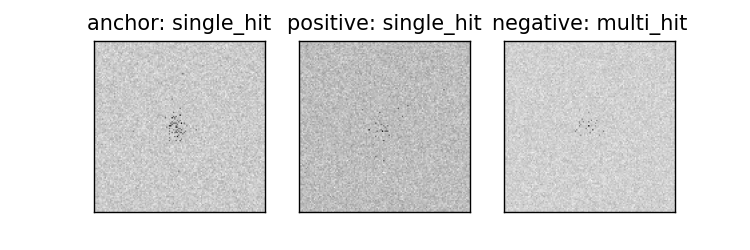

In [12]:
# visualize a batch of triplet
triplet, labels = create_batch(batch_size=1, anchor_label=0)
plot_triplet(triplet, labels)

In [13]:
# Embedding model (2 dense layers w/ relu and sigmoid activation)
#### Play with this value during testing.
emb_dim = 64

# Dense implements the operation: output = activation(dot(input, kernel) + bias)

#### TODO: Implement CNN or Resnet model you want for embeddings here
embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(emb_dim, activation='relu', input_shape=(img_dim,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 1,052,800
Trainable params: 1,052,800
Non-trainable params: 0
_________________________________________________________________


In [14]:
example = x_train[0]
example_emb = embedding_model.predict(np.expand_dims(example, axis=0))
print("example embedding: ", example_emb, example_emb.shape)

example embedding:  [[0.25643435 0.56616706 0.3369849  0.41602308 0.60778874 0.5972469
  0.8243507  0.62169564 0.8750636  0.6938843  0.23309164 0.8047184
  0.5852865  0.91861355 0.5197183  0.73131394 0.58002394 0.54021496
  0.4547101  0.34354824 0.61263824 0.81549823 0.23783308 0.90533656
  0.42270237 0.5596344  0.3165386  0.6228274  0.64491564 0.79476064
  0.4882448  0.6981951  0.21501227 0.77614605 0.6159177  0.59144175
  0.42343926 0.87332153 0.7092805  0.61117935 0.89618695 0.5197718
  0.69533515 0.43601358 0.50145507 0.17894696 0.55472934 0.12479625
  0.43161777 0.21707118 0.28597888 0.52183914 0.63573265 0.34365168
  0.22755185 0.5563324  0.5990213  0.78627974 0.63079286 0.78521603
  0.72784114 0.57520926 0.18765925 0.67078704]] (1, 64)


<IPython.core.display.Javascript object>


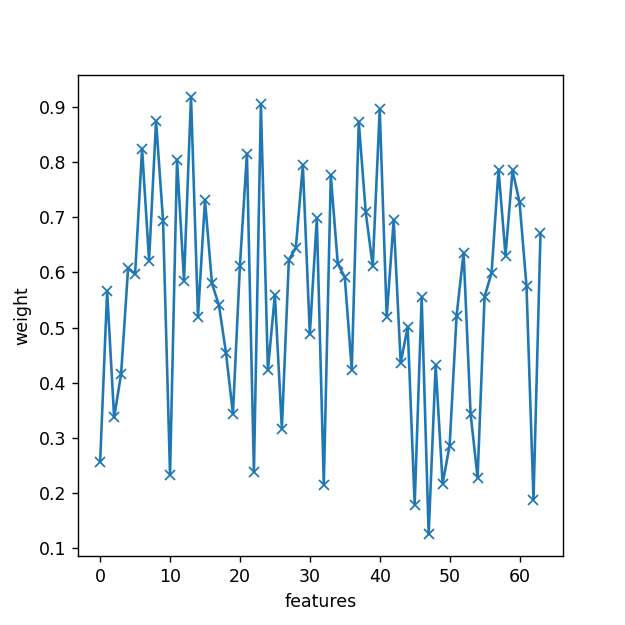

In [15]:
plt.figure(figsize=(5,5))
plt.plot(example_emb[0],'x-'); plt.xlabel("features"); plt.ylabel("weight"); plt.show()

In [16]:
# Siamese network
in_anc = tf.keras.layers.Input(shape=(img_dim,))
in_pos = tf.keras.layers.Input(shape=(img_dim,))
in_neg = tf.keras.layers.Input(shape=(img_dim,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)

net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16384)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           1052800     input_1[0][0]                    
                                                                 input_2[0][0]                

# Triplet Loss
A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [17]:
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [18]:
class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(10, 10))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
            self.ax2.set_title('Loss vs Epochs')
        self.ax1.set_title('PCA embedding of Siamese embedding')
        self.ax1.set_xlabel('principal component 1')
        self.ax1.set_ylabel('principal component 2')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

In [19]:
# data generation
def data_generator(batch_size, emb_dim):
    while True:
        x, _ = create_batch(batch_size=batch_size)    # Without anchor_label
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

## Model Training

In [20]:
# model training

#### TODO: Run bigger batch size on SDF or another psana node.
batch_size = 200   #### BEWARE: Setting batch_size too high will result in a UnboundLocalError involving a log variable.
epochs = 100
steps_per_epoch = int(num_train/batch_size)
alpha = 0.95

net.compile(loss=triplet_loss(alpha=alpha, emb_dim=emb_dim), optimizer='adam')

X, Y = x_test[:1000], y_test[:1000]

<IPython.core.display.Javascript object>


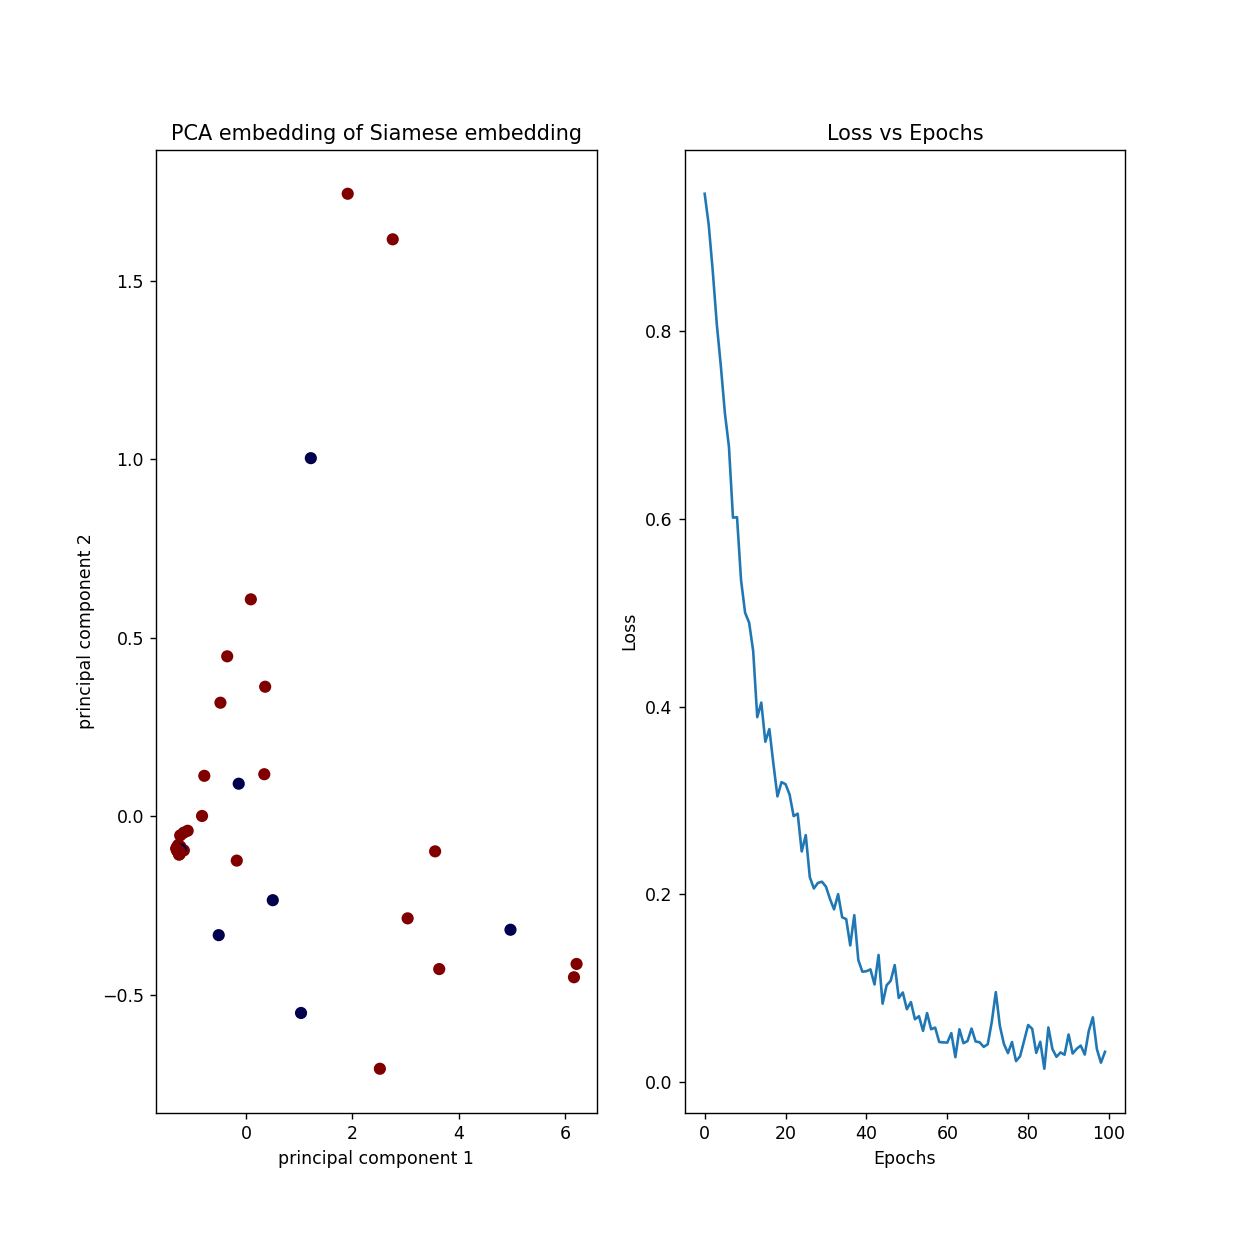

In [21]:
_ = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=False,
    callbacks=[
        PCAPlotter(plt, embedding_model, X, Y)
    ]
)

## Analysis

In [22]:
# https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352

def compute_dist(a,b):
    return np.sum(np.square(a-b))

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                else:
                    y[k] = 0
                k += 1
    return probs,y

from sklearn.metrics import roc_auc_score, roc_curve
def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds, auc

In [23]:
n_val = 100
probs,yprob = compute_probs(embedding_model,x_test[:n_val],y_test[:n_val])

In [24]:
fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
print(fpr)
print(tpr)

[0.         0.         0.         0.00664452 0.00664452 0.00996678
 0.00996678 0.01328904 0.01328904 0.0166113  0.0166113  0.01993355
 0.01993355 0.02325581 0.02325581 0.02657807 0.02657807 0.02990033
 0.02990033 0.03322259 0.03322259 0.03654485 0.03654485 0.03986711
 0.03986711 0.04318937 0.04318937 0.04651163 0.04651163 0.04983389
 0.04983389 0.05647841 0.05647841 0.05980066 0.05980066 0.06312292
 0.06312292 0.06644518 0.06644518 0.06976744 0.06976744 0.0730897
 0.0730897  0.07641196 0.07641196 0.08305648 0.08305648 0.089701
 0.089701   0.09302326 0.09302326 0.09966777 0.09966777 0.10299003
 0.10299003 0.10631229 0.10631229 0.11960133 0.11960133 0.12624585
 0.12624585 0.1461794  0.1461794  0.14950166 0.14950166 0.17940199
 0.17940199 0.18604651 0.18604651 0.18936877 0.18936877 0.19601329
 0.19601329 0.19933555 0.19933555 0.20598007 0.20598007 0.21262458
 0.21262458 0.2192691  0.2192691  0.22259136 0.22259136 0.22591362
 0.22591362 0.22923588 0.22923588 0.23255814 0.23255814 0.2392026

/reg/data/ana03/scratch/yoon82/conda/ana-py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


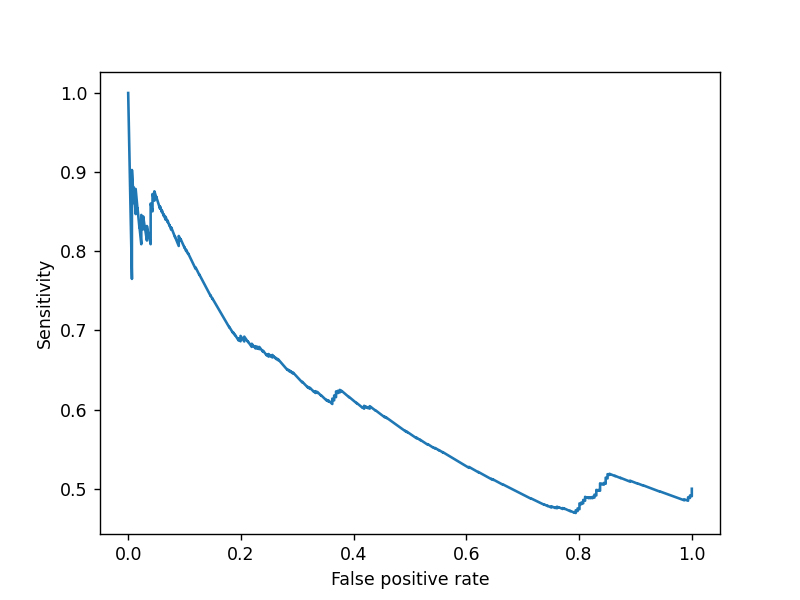

In [25]:
# Plot sensitivity as function of false positive rate (fpr)
sensitivity = tpr/(fpr+tpr)
plt.figure()
plt.plot(fpr,sensitivity); 
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity')
plt.show()

<IPython.core.display.Javascript object>


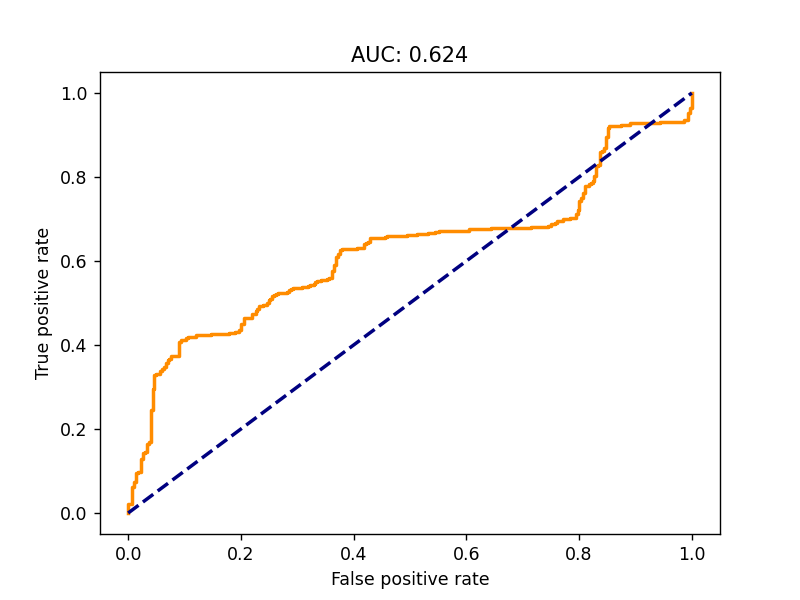

In [26]:
# ROC curve and Area under the curve (AUC)
plt.figure()
plt.plot(fpr,tpr, color='darkorange', lw=2, linestyle='-');
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlabel('False positive rate'); 
plt.ylabel('True positive rate');
plt.title('AUC: {:.3f}'.format(auc))
plt.show()

<IPython.core.display.Javascript object>


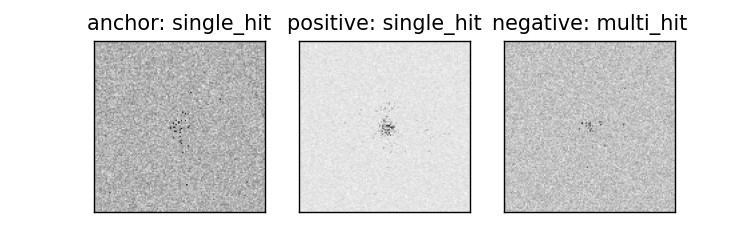

Dp: 0.9998909300380434, Dn: 7.936931797394238
64


In [27]:
# Print Dp and Dn
triplet, labels = create_batch(batch_size=1, anchor_label=0)

myBatch = np.zeros((3, emb_dim))
myBatch[0,:] = embedding_model.predict(triplet[0])
myBatch[1,:] = embedding_model.predict(triplet[1])
myBatch[2,:] = embedding_model.predict(triplet[2])
plot_triplet(triplet, labels)

from scipy.spatial.distance import cdist
Y = cdist(myBatch, myBatch, 'euclidean')
print("Dp: {}, Dn: {}".format(Y[0,1],Y[0,2]))

print(len(myBatch[0]))

<IPython.core.display.Javascript object>


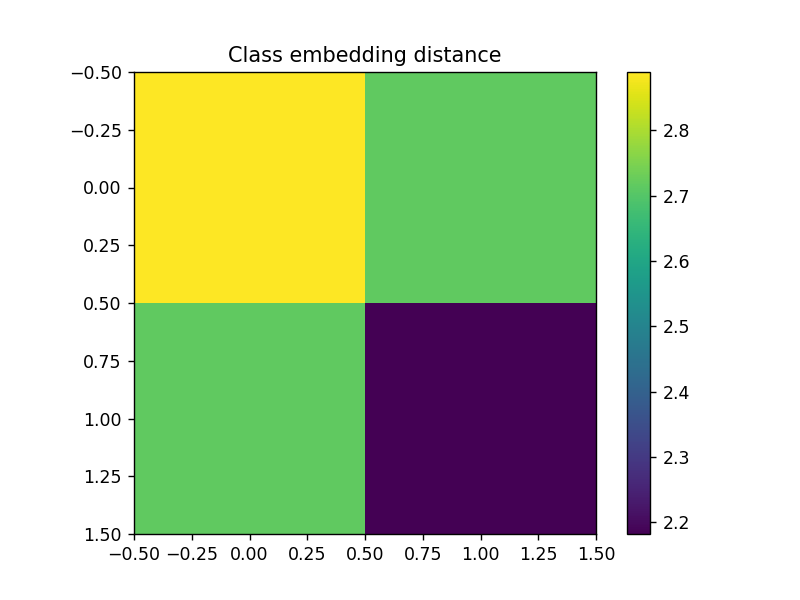

In [28]:
# Look at class embedding distance

# Embed first 1000 test images
num_sample = 50
num_classes = 2
junk = x_test[:num_sample]
junky = y_test[:num_sample]
emb_junk = np.zeros((num_sample,emb_dim))
for i in range(num_sample):
    emb_junk[i,:] = embedding_model.predict(np.expand_dims(junk[i,:], axis=0)) 

# Calculate euclidean distance between embeddings
Y = cdist(emb_junk,emb_junk,'euclidean')

# Populate class embedding distance matrix
distance_matrix = np.zeros((num_classes,num_classes))
counter = np.zeros((num_classes,num_classes))
for i in range(num_sample):
    for j in range(i+1,num_sample):
        class1 = junky[i]
        class2 = junky[j]
        distance_matrix[class1,class2] += Y[i,j]
        distance_matrix[class2,class1] += Y[i,j]
        counter[class1,class2] += 1
        counter[class2,class1] += 1
distance_matrix = distance_matrix/counter

# Visualize
plt.figure(); plt.imshow(distance_matrix,interpolation='None'); 
plt.title("Class embedding distance"); plt.colorbar(); plt.show()

In [29]:
# See which classes are hard and easy to distinguish from each other

myClass = 0 # Choose a digit here

# select hardest and easiest classes based on mean distance
dist = distance_matrix[myClass,:] 
challenging = np.argsort(dist)
hardest = None
hscore = 0
easiest = None
escore = 0
cscore = dist[myClass]
for i in challenging:
    if i != myClass:
        hardest = i
        hscore=dist[i]
        break
for i in reversed(challenging):
    if i != myClass:
        easiest = i
        escore=dist[i]
        break        
print("For PDB {} ({:.3f}), hardest class to distinguish is digit {} ({:.3f}) and easiest digit is {} ({:.3f})"
      .format(idx2hit[myClass],cscore,idx2hit[hardest],hscore,idx2hit[easiest],escore))

For PDB single_hit (2.889), hardest class to distinguish is digit multi_hit (2.717) and easiest digit is multi_hit (2.717)


# Retabulate y_true and y_pred.
At the moment, y_true and y_pred contains idx2count values for the individual particle counts used: 0 = single, 1 = double, 2 = triple, and 3 = quadruple. Here, we will turn this multi-classification into a binary classification, where 0 = single-hit images and 1 = multi-hit images (of double, triple, and quadruple).

#### Make some predictions

In [30]:
def get_predictions_from_embeddings(embeddings, test_labels, emb_dim):
    
    # Retrieve the anchor, positive, and negative embeddings.
    anc, pos, neg = embeddings[:, :emb_dim], embeddings[:, emb_dim:2*emb_dim], embeddings[:, 2*emb_dim:]
    
    y_pred = np.zeros(len(embeddings), dtype=int)
    
    for i in range(len(embeddings)):
        batch_embeddings = np.zeros((3, emb_dim))
        batch_embeddings[0,:] = anc[i]
        batch_embeddings[1,:] = pos[i]
        batch_embeddings[2,:] = neg[i]
        
        Y = cdist(batch_embeddings, batch_embeddings, 'euclidean')
        dp = Y[0,1]
        dn = Y[0,2]
        
        anchor_label = test_labels[0][i].item()
        pos_label = test_labels[1][i].item()
        neg_label = test_labels[2][i].item()
        
        # Debug
        #print('Anchor: {}'.format(anchor_label))
        #print('Positive: {}'.format(pos_label))
        #print('Negative: {}'.format(neg_label))
        #print('dp: {}'.format(dp))
        #print('dn: {}'.format(dn))
        
        if (anchor_label == hit2idx['single_hit']) and (pos_label == hit2idx['single_hit']):
        
            # The anchor and positive images are SINGLE-HIT images. So if dp < dn, the network classifies a SINGLE-HIT image.
            if (dp < dn):
                y_pred[i] = hit2idx['single_hit']
            else:
                y_pred[i] = hit2idx['multi_hit']
        
        elif (anchor_label == hit2idx['multi_hit']) and (pos_label == hit2idx['multi_hit']):
            
            # The anchor and positive images are MULTI-HIT images. So if dp < dn, the network classifies a MULTI-HIT image.
            if (dp < dn):
                y_pred[i] = hit2idx['multi_hit']
            else:
                y_pred[i] = hit2idx['single_hit']
        
        else:
            # Not sure what to put here.
            pass
            
    
    return y_pred

In [37]:
test_batch_size = 1000

# Create a batch to get accuracy, precision, recall, and F1 scores from.
x_test, y_test = create_batch(batch_size=test_batch_size)

# Get y_true.
y_true = np.ones(test_batch_size, dtype=int)
for i in range(test_batch_size):
    
    # If anchor and positive image are single-hit
    if y_test[0][i].item() == 0 and y_test[1][i].item() == 0:
        y_true[i] = hit2idx['single_hit']
    elif y_test[0][i].item() == 1 and y_test[0][i].item() == 1:
        y_true[i] = hit2idx['multi_hit']
    else:
        pass

# Get embeddings for the batch.
predict_embeddings = net.predict(x_test)

# Classify embeddings
y_pred = get_predictions_from_embeddings(embeddings=predict_embeddings, test_labels=y_test, emb_dim=emb_dim)


#print('Predicted values: ' + str(y_pred))
#print('True values: ' + str(y_true))

# Accuracy, Precision, Recall, and F1 Score

In [38]:
import sklearn.metrics

def accuracy_precision_recall_and_f1(y_true, y_pred):
    
    """
    Returns the precision, recall, and F1 scores.
    
    Parameters
    ----------
    y_true -> An array of the correct target values. 0 means single-hit and 1 means multi-hit (so double, triple, or quadruple).
    y_false -> An array of the predicted target values by model. 0 means single-hit and 1 means multi-hit (so double, triple, or quadruple)
    """

    accuracy = sklearn.metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
    
    # pos_label = 0 to return precision for classifying single-hit images.
    precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label=0, average='binary', zero_division='warn')

    # pos_label = 0 to return recall for classifying single-hit images.
    recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label=0, average='binary', zero_division='warn')

    # pos_label = 0 to return F1 score for classifying single-hit images.
    f1_score = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, pos_label=0, average='binary', zero_division='warn')
    
    return accuracy, precision, recall, f1_score

In [39]:
accuracy, precision, recall, f1 = accuracy_precision_recall_and_f1(y_true, y_pred)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Accuracy: 0.992
Precision: 1.0
Recall: 0.9655172413793104
F1 Score: 0.9824561403508771
